In [1]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image, ImageChops
from sklearn.neighbors import KernelDensity
import random
import shutil
import tensorflow as tf

import glob

In [ ]:
% matplotlib inline

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls   #check if mounted correctly

DATADIR = "/content/gdrive/My Drive/cpu_autoencoder_2/train"
os.listdir('/content/gdrive/My Drive/cpu_autoencoder_2/train')     #show directories in base directory

Mounted at /content/gdrive
gdrive	sample_data


['gpu_stress', 'idle']

In [5]:
Classes = ["idle","gpu_stress"]

In [6]:
import random
for cl in Classes:
  img_path = os.path.join(DATADIR, cl)    # Merge DATADIR with class name
  print(img_path)
  images = glob.glob(img_path + '/*.jpg')   # Take path name and include everything with .jpg. Return list of all images
  random.shuffle(images)                    # randomly shuffle list
  print("{}: {} Images". format(cl,len(images)))
  num_train = int(round(len(images)*0.7))     # Find what 70% of images is
  train, val = images[:num_train], images[num_train:]   # Assign 70% and 30% of images to training and validation datasets respectively. list starting at index 0 up to but not including num_train

  for t in train:
    if not os.path.exists(os.path.join(DATADIR, 'train', cl)):
      os.makedirs(os.path.join(DATADIR, 'train', cl))
    shutil.move(t, os.path.join(DATADIR, 'train', cl))      # Move images to train directory

  for v in val:
    if not os.path.exists(os.path.join(DATADIR, 'val', cl)):
      os.makedirs(os.path.join(DATADIR, 'val', cl))
    shutil.move(v, os.path.join(DATADIR, 'val', cl))        #Move images to val director

/content/gdrive/My Drive/cpu_autoencoder_2/train/idle
idle: 400 Images
/content/gdrive/My Drive/cpu_autoencoder_2/train/gpu_stress
gpu_stress: 400 Images


In [7]:
batch_size = 64
IMG_width = 160
IMG_height= 160

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/My Drive/cpu_autoencoder_2/train/idle_cpu_autoencoder',
    target_size=(IMG_height, IMG_width),
    batch_size=batch_size,
    class_mode='input'
    )

val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
validation_generator = val_datagen.flow_from_directory(
    '/content/gdrive/My Drive/cpu_autoencoder_2/val/idle_cpu_autoencoder',
    target_size=(IMG_height, IMG_width),
    batch_size=batch_size,
    class_mode='input'      #Use for Autoencoders because there is one class, its input and output
    )

anomaly_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
anomaly_generator = anomaly_datagen.flow_from_directory(
    '/content/gdrive/My Drive/cpu_autoencoder_2/train/cpu_stress_autoencoder',
    target_size=(IMG_height, IMG_width),
    batch_size=batch_size,
    class_mode='input'
    )

images = glob.glob('/content/gdrive/My Drive/cpu_autoencoder_2/train/idle_cpu_autoencoder/idle_cpu' + '/*.jpg')   # Take path name and include everything with .jpg. Return list of all images
print("{}: {} Images". format('train:idle_cpu_autoencoder',len(images)))

images = glob.glob('/content/gdrive/My Drive/cpu_autoencoder_2/val/idle_cpu_autoencoder/idle_cpu' + '/*.jpg')   # Take path name and include everything with .jpg. Return list of all images
print("{}: {} Images". format('val:idle_cpu_autoencoder',len(images)))

images = glob.glob('/content/gdrive/My Drive/cpu_autoencoder_2/train/cpu_stress_autoencoder/cpu_stress' + '/*.jpg')   # Take path name and include everything with .jpg. Return list of all images
print("{}: {} Images". format('test:cpu_stress_autoencoder',len(images)))


Found 560 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
train:idle_cpu_autoencoder: 0 Images
val:idle_cpu_autoencoder: 0 Images
test:cpu_stress_autoencoder: 400 Images


In [9]:
# Define the convolutional autoencoder model 
# input shape must be the same size as the images that will be fed into it by the generators
# The output layer must be the same dimensions as the original image
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same',activation='relu', input_shape=(IMG_height, IMG_width, 3)))
model.add(MaxPooling2D(pool_size=(2,2), padding='same')) # using pool_size (2,2) makes the layer 2x smaller in height and width

model.add(Conv2D(8,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#-------------------------

model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(8,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(16,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3,(3, 3), activation='sigmoid', padding='same'))
#-------------------------

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 3)         219       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 3)         8

In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# Training the model
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20) # Early stopping (stops training when validation doesn't improve for {patience} epochs).  min_delta=1 to abort if improvement is less than 1%. verbose displayes last epoch
model_filepath = 'models/cpu_stress_autoencoder_v4.keras'
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min',  verbose=1) # Saves the best version of the model to disk (as measured on the validation data set)
model.fit(
        train_generator,        #add accuracy metric
        steps_per_epoch=int(np.ceil(train_generator.n / float(batch_size))),
        epochs=600,
        validation_data=validation_generator,
        validation_steps=int(np.ceil(validation_generator.n / float(batch_size))),
        shuffle = True,
        callbacks=[es, save_best])

Epoch 1/600
9/9 [==============================] - 151s 13s/step - loss: 0.0854 - val_loss: 0.0766

Epoch 00001: val_loss improved from inf to 0.07662, saving model to models/cpu_stress_autoencoder_v4.keras
Epoch 2/600
9/9 [==============================] - 2s 195ms/step - loss: 0.0687 - val_loss: 0.0379

Epoch 00002: val_loss improved from 0.07662 to 0.03791, saving model to models/cpu_stress_autoencoder_v4.keras
Epoch 3/600
9/9 [==============================] - 2s 194ms/step - loss: 0.0358 - val_loss: 0.0234

Epoch 00003: val_loss improved from 0.03791 to 0.02341, saving model to models/cpu_stress_autoencoder_v4.keras
Epoch 4/600
9/9 [==============================] - 2s 202ms/step - loss: 0.0246 - val_loss: 0.0202

Epoch 00004: val_loss improved from 0.02341 to 0.02025, saving model to models/cpu_stress_autoencoder_v4.keras
Epoch 5/600
9/9 [==============================] - 2s 197ms/step - loss: 0.0196 - val_loss: 0.0185

Epoch 00005: val_loss improved from 0.02025 to 0.01851, savi

In [12]:
# Training continues after improvement stops for the number of epochs equivalent to the 'patience' hyper-parameter
# To get back the model that performed best on the validation set we load the checkpointed model from disk:
model = keras.models.load_model(model_filepath)
# model = keras.models.load_model('./models/cpu_stress_autoencoder.keras')

In [13]:
model_filepath      #check model name

'models/cpu_stress_autoencoder_v4.keras'

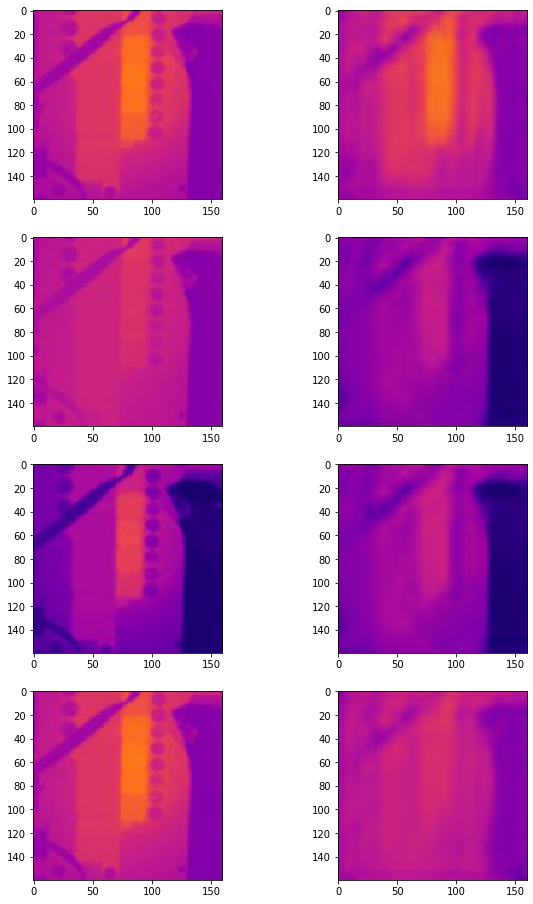

In [14]:
# Test the model by viewing a sample of original and reconstructed images of training dataset 
data_list = []
batch_index = 0
while batch_index <= train_generator.batch_index:
    data = train_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1

predicted = model.predict(data_list[0])
no_of_samples = round(len(train_generator)/2)    #3 because thats how many objects in train_generator iterator
_, axs = plt.subplots(nrows=no_of_samples, ncols=2, figsize=(10, 16))   #axs is the location of the fig

axs = axs.flatten()
imgs = []
for i in range(no_of_samples):    
    imgs.append(data_list[i][i])
    imgs.append(predicted[i])


for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

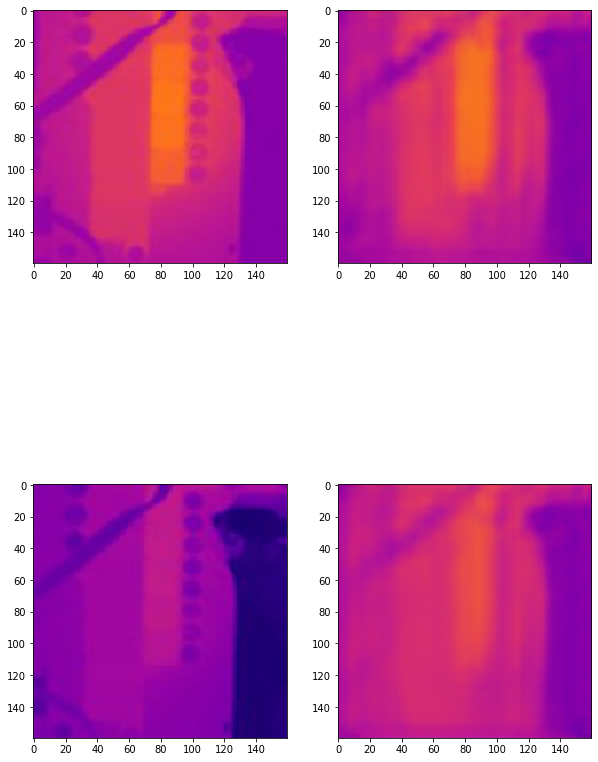

In [15]:
# Test the model by viewing a sample of original and reconstructed images of validation dataset
data_list = []
batch_index = 0
while batch_index <= validation_generator.batch_index:
    data = validation_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1

predicted = model.predict(data_list[0])
no_of_samples = round(len(validation_generator)/2)        #3 because thats how many objects in train_generator iterator
_, axs = plt.subplots(nrows=no_of_samples, ncols=2, figsize=(10, 16))   #axs is the location of the fig

axs = axs.flatten()
imgs = []
for i in range(no_of_samples):    
    imgs.append(data_list[i][i])
    imgs.append(predicted[i])


for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

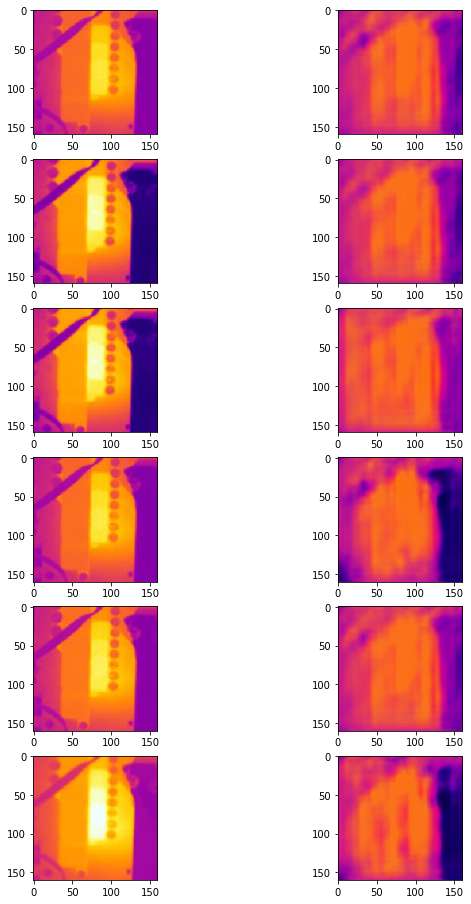

In [16]:
# Test the model by viewing a sample of original and reconstructed images of anomaly dataset
data_list = []
batch_index = 0
while batch_index <= anomaly_generator.batch_index:
    data = anomaly_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1

predicted = model.predict(data_list[0])
no_of_samples = round(len(anomaly_generator)/2)     #3 because thats how many objects in train_generator iterator
_, axs = plt.subplots(nrows=no_of_samples, ncols=2, figsize=(10, 16))   #axs is the location of the fig

axs = axs.flatten()
imgs = []
for i in range(no_of_samples):    
    imgs.append(data_list[i][i])
    imgs.append(predicted[i])


for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [17]:

# We want the difference the difference in error between the validation (normal) images and anomalous images to be as high as possible
print(f"Error on validation set:{model.evaluate(validation_generator)}, error on anomaly set:{model.evaluate(anomaly_generator)}")

13/13 [==============================] - 2s 125ms/step - loss: 0.0289
Error on validation set:0.0007127368007786572, error on anomaly set:0.02887837216258049


In [18]:
# We build a replica of the first half of the auto-encoder (the encoder only)
# This network takes a an image which is 96x96x3 and compresses it down to a 3x3x3 tensor
encoder_replica = Sequential()
encoder_replica.add(Conv2D(16, (3, 3), padding='same',activation='relu', input_shape=(IMG_height, IMG_width, 3), weights=model.layers[0].get_weights(), name='encoder_conv_1') )    #get weights from original model
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same', name='encoder_maxpool_1'))
encoder_replica.add(Conv2D(8,(3, 3),activation='relu',  padding='same', weights=model.layers[2].get_weights(), name='encoder_conv_2'))
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same', name='encoder_maxpool_2'))
encoder_replica.add(Conv2D(3,(3, 3),activation='relu',  padding='same', weights=model.layers[4].get_weights(), name='encoder_conv_3'))
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same', name='encoder_maxpool_3'))
encoder_replica.add(Conv2D(3,(3, 3),activation='relu',  padding='same', weights=model.layers[6].get_weights(), name='encoder_conv_4'))
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same', name='encoder_maxpool_4'))
encoder_replica.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_conv_1 (Conv2D)      (None, 160, 160, 16)      448       
_________________________________________________________________
encoder_maxpool_1 (MaxPoolin (None, 80, 80, 16)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 80, 80, 8)         1160      
_________________________________________________________________
encoder_maxpool_2 (MaxPoolin (None, 40, 40, 8)         0         
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 40, 40, 3)         219       
_________________________________________________________________
encoder_maxpool_3 (MaxPoolin (None, 20, 20, 3)         0         
_________________________________________________________________
encoder_conv_4 (Conv2D)      (None, 20, 20, 3)        

In [19]:
encoder_replica.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
encoder_replica.save("cpu_stress_encoder")

INFO:tensorflow:Assets written to: cpu_stress_encoder/assets


In [21]:
#zip a folder under /content/Folder_To_Zip
!zip -r /content/file.zip  /content/cpu_stress_encoder

  adding: content/cpu_stress_encoder/ (stored 0%)
  adding: content/cpu_stress_encoder/saved_model.pb (deflated 90%)
  adding: content/cpu_stress_encoder/assets/ (stored 0%)
  adding: content/cpu_stress_encoder/variables/ (stored 0%)
  adding: content/cpu_stress_encoder/variables/variables.data-00000-of-00001 (deflated 30%)
  adding: content/cpu_stress_encoder/variables/variables.index (deflated 54%)


In [22]:
model.save("cpu_stress_autoencoder")

INFO:tensorflow:Assets written to: cpu_stress_autoencoder/assets


In [23]:
#zip a folder under /content/Folder_To_Zip
!zip -r /content/file1.zip  /content/cpu_stress_autoencoder

  adding: content/cpu_stress_autoencoder/ (stored 0%)
  adding: content/cpu_stress_autoencoder/saved_model.pb (deflated 90%)
  adding: content/cpu_stress_autoencoder/assets/ (stored 0%)
  adding: content/cpu_stress_autoencoder/variables/ (stored 0%)
  adding: content/cpu_stress_autoencoder/variables/variables.data-00000-of-00001 (deflated 24%)
  adding: content/cpu_stress_autoencoder/variables/variables.index (deflated 73%)


In [24]:
# get dimensions of the last layer of 'encoder_replica' model
layer=encoder_replica.get_layer('encoder_maxpool_4')
layer_list=layer.get_output_at(0).get_shape().as_list()
dim= layer_list[1]*layer_list[2]*layer_list[3]



print("Last layer has dimensions: {}*{}*{}". format(layer_list[1],layer_list[2],layer_list[3]))
print("Product of layer dimensions: {}". format(dim))


Last layer has dimensions: 10*10*3
Product of layer dimensions: 300


In [25]:
# Creating encoded (compressed versions of the training, validation and anomalous images) and getting their density
# The SKLearn kernel density function only works with 1D arrays so we need to flatten the tensors created by the encoder

encoded_images = encoder_replica.predict(train_generator)
encoded_images_flat = [np.reshape(img, (dim)) for img in encoded_images]      #to get the second argument multiply the dimensions in encoded_images: 12*12*3=432. Do this to flatten image

validation_encoded = encoder_replica.predict(validation_generator)
val_enc_flat = [np.reshape(img, (dim)) for img in validation_encoded]

anom_encoded = encoder_replica.predict(anomaly_generator)
anom_enc_flat = [np.reshape(img, (dim)) for img in anom_encoded]

In [26]:
np.savetxt("cpu_encoded_images_flat.csv", encoded_images_flat, delimiter=",")
np.savetxt("cpu_val_enc_flat.csv", val_enc_flat, delimiter=",")

205.0509504532368
[205.29899375 204.80937499 205.19024697 204.07109461 205.09538689
 204.0375884  203.98235536 205.05117702 205.24071101 205.35139383
 205.25466165 205.11832387 203.60996084 205.36792625 204.63727618
 205.35963171 205.33680281 204.07744329 204.97952528 204.46016409
 204.38210356 205.32946359 204.27600466 205.27839931 203.79978019
 204.23954705 204.01793569 204.97237455 205.18014036 205.28198576
 205.11566744 205.1271148  205.05165101 205.15655335 204.90527271
 204.98740474 200.82771457 205.21252291 205.32546296 205.29951493
 204.67244494 204.16640109 204.06104737 203.30047426 204.66691537
 205.13832494 205.24573484 205.16705817 204.61541156 205.1046008
 204.36823056 203.97539904 203.72481539 205.24320773 204.07929268
 204.07392466 205.28991258 204.28362035 204.88888177 205.39052478
 205.33439375 204.40079801 205.3067829  205.03894269 205.05757923
 203.98135165 205.2985085  205.24651754 205.06620291 201.46102713
 203.83634989 204.87524077 205.31596134 203.81827929 205.28

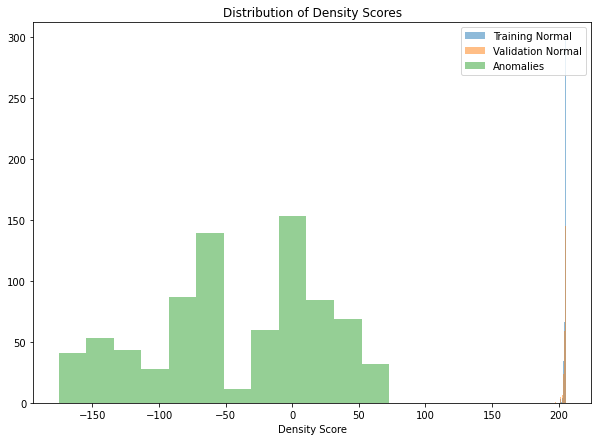

In [27]:

# Kernel Density Estimation of the encoded vectors
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_flat)        # kernel density is a tool used to make discrete values smooth. bandwidth is how smooth it is. kernel is the function used. check https://mathisonian.github.io/kde/
training_density_scores = kde.score_samples(encoded_images_flat) 
print(np.median(training_density_scores))
print(training_density_scores)

validation_density_scores = kde.score_samples(val_enc_flat)
print(np.median(validation_density_scores))
print(validation_density_scores)

anomaly_density_scores = kde.score_samples(anom_enc_flat)
print(np.median(anomaly_density_scores))
print(anomaly_density_scores)



# Plotting the density distributions of the training (normal), validation (normal) and anomalous images
# Ideally we want to see high separation between the normal and anomalous classes
plt.figure(figsize = (10,7))
plt.title('Distribution of Density Scores')
plt.hist(training_density_scores, 12, alpha=0.5, label='Training Normal')
plt.hist(validation_density_scores, 12, alpha=0.5, label='Validation Normal')
plt.hist(anomaly_density_scores, 12, alpha=0.5, label='Anomalies')
plt.legend(loc='upper right')
plt.xlabel('Density Score')

plt.show()

In [29]:
# sorted_validation_density_scores=np.sort(validation_density_scores)
# print(sorted_validation_density_scores)

min_quantile = np.quantile(validation_density_scores, 0.01)   #obtain 0.01 smallest value on validatation density score
max_quantile = np.quantile(validation_density_scores, 0.99)   #obtain 0.99 biggest value on validatation density score

min_quantile_threshold=min_quantile - 10          #change 10 to a number based on tolerance level
max_quantile_threshold= max_quantile + 10         #change 10 to a number based on tolerance level

In [30]:
# Create a function for classifying images in bulk (for testing purposes)
def get_mse(original, reconstruction):
    # Returns the mean square error for each image in the array
    return np.mean((original - reconstruction)**2, axis=(1,2,3)) 

def evaluate_model(test_file):
    # density_threshold = 175 # This threshold was chosen based on looking at the distribution of the density scores of the normal class (validation set)
    reconstruction_error_threshold = 0.020 # This threshold was chosen based on looking at the distribution of reconstruction errors of the normal class
    batch_size  = 0
    for (dirpath, dirnames, filenames) in os.walk(test_file):
        batch_size += len([file for file in filenames if file.endswith(".jpg")]) # Batchsize now is total images in folder
    
    test_img_generator = train_datagen.flow_from_directory(
    test_file,
    target_size=(IMG_height, IMG_width),
    batch_size=batch_size,
    class_mode='input'
    )
    
    images = test_img_generator.next()[0]   #load test images to variable images
    reconstructions = model.predict(images) #get reconstructed images
    MSEs = get_mse(images, reconstructions) #get mse
    reconstruction_anomalies = MSEs > reconstruction_error_threshold
    print(f'Reconstruction anomalies = {sum(reconstruction_anomalies)}')
    
    encoded_images = encoder_replica.predict(test_img_generator)
    encoded_images_flat = np.array([np.reshape(img, (dim)) for img in encoded_images])        #change argument (dim) to last layer dimensions product
    density_scores = kde.score_samples(encoded_images_flat)

    density_anomalies_min= density_scores < min_quantile_threshold      # check if desnity score is samller than threshold
    density_anomalies_max= density_scores > max_quantile_threshold      # check if desnity score is bigger than threshold
    density_anomalies = density_anomalies_min != density_anomalies_max    # get the resultant. example: density_anomalies_min= True,  density_anomalies_min= False ==> density_anomalies= True


    combined_anomalies = np.maximum(reconstruction_anomalies, density_anomalies)
    print(f'Combined anomalies = {sum(combined_anomalies)}')
    overall_detection_rate = sum(combined_anomalies) / len(combined_anomalies)
    print(f'Overall detection rate = {overall_detection_rate}')
    return  MSEs

In [32]:
# Check what proportion of normal images get classified as anomalous
MSE_normal=evaluate_model('/content/gdrive/My Drive/cpu_autoencoder_2/train/idle_cpu_autoencoder')

Found 560 images belonging to 2 classes.
Reconstruction anomalies = 0
Combined anomalies = 0
Overall detection rate = 0.0


In [33]:
# Check what proportion of validation images get classified as anomalous
MSE_val=evaluate_model('/content/gdrive/My Drive/cpu_autoencoder_2/val/idle_cpu_autoencoder')

Found 240 images belonging to 2 classes.
Reconstruction anomalies = 0
Combined anomalies = 0
Overall detection rate = 0.0


In [34]:
# Check what proportion of anomaly images (a set which was unseen in training) get classified as anomalous
MSE_anom=evaluate_model('/content/gdrive/My Drive/cpu_autoencoder_2/train/cpu_stress_autoencoder')

Found 800 images belonging to 2 classes.
Reconstruction anomalies = 604
Combined anomalies = 800
Overall detection rate = 1.0


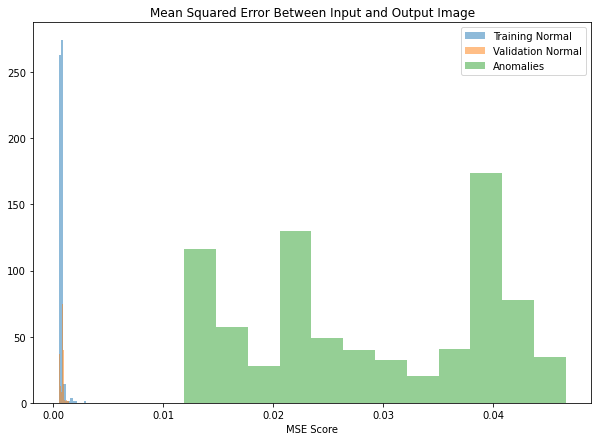

In [35]:
plt.figure(figsize = (10,7))
plt.title('Mean Squared Error Between Input and Output Image')
plt.hist(MSE_normal, 12, alpha=0.5, label='Training Normal')
plt.hist(MSE_val, 12, alpha=0.5, label='Validation Normal')
plt.hist(MSE_anom, 12, alpha=0.5, label='Anomalies')
plt.legend(loc='upper right')
plt.xlabel('MSE Score')

plt.show()

In [ ]:
# This function can be used for ingference when the system is deployed it checks one image at a time
def check_anomaly(img_path):
    # density_threshold = 0 
    reconstruction_error_threshold = 0.020
    img  = Image.open(img_path)
    img = np.array(img.resize((IMG_height, IMG_width), Image.ANTIALIAS))
    img = img / 255
    img = tf.expand_dims(img, 0)

    encoded_img = encoder_replica.predict(img) # Create a compressed version of the image using the encoder
    encoded_img = [np.reshape(img, (dim)) for img in encoded_img] # Flatten the compressed image
    density = kde.score_samples(encoded_img)[0] # get a density score for the new image
    print(f'density: {density}')
    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)
    print(f'reconstruction_error: {reconstruction_error}')
    if density < min_quantile_threshold or density > max_quantile_threshold or reconstruction_error > reconstruction_error_threshold:
        print("This image is normal")
    else:
        print("This image is anomaly")

In [ ]:
test_image = "/content/gdrive/My Drive/cpu_stress_encoder/train/cpu_stress_autoencoder/cpu_stress/FLIR2008Cropped.jpg"
check_anomaly(test_image)

density: 84.86099350178088
1/1 [==============================] - 0s 13ms/step - loss: 0.0458
reconstruction_error: 0.04577178135514259
This image is anomaly
